# How to: Build a simple neural network with TensorFlow Eager

Hello everyone! In this tutorial we are going to build a simple feedforward neural network
using the imperative mode of TensorFlow. Hope you will find it useful! If you have any suggestions on how I can improve the code, please let me know. 

**Version used: TensorFlow 1.5**

## Step 1: Import useful libraries and enable eager mode
----

In [1]:
# Suppress future warnings
import warnings 
warnings.simplefilter(action='ignore', category=FutureWarning)

# Import TensorFlow and TensorFlow Eager
import tensorflow as tf
import tensorflow.contrib.eager as tfe

# Import function to generate toy classication problem
from sklearn.datasets import make_moons
import numpy as np

# Import library for plots
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Enable eager mode. Once activated it cannot be reversed! Run just once.
tfe.enable_eager_execution()

## Step 2: Generate toy dataset for binary classification
----
We will generate a toy dataset, to train our network. I chose the make_moons function from sklearn. I believe it is perfect for our task, as the classes are not linearly separable, so a neural network fits perfectly here.

In [3]:
# Generate toy dataset for classification
# X is a matrix of n_samples x n_features and represents the input features
# y is a vector with length n_samples and represents our targets
X, y = make_moons(n_samples=100, noise=0.1, random_state=2018)

## Step 3: Visualize generated dataset
----

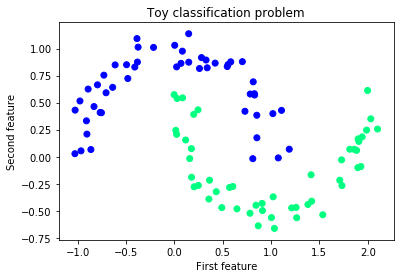

In [4]:
plt.scatter(X[:,0], X[:,1], c=y, cmap=plt.cm.winter)
plt.xlabel('First feature')
plt.ylabel('Second feature')
plt.title('Toy classification problem')
plt.show()

## Step 4: Build a single hidden layer neural  network (Linear -> ReLU -> Linear output)
----
Our first trial is a simple neural network with a single hidden layer. 

In [5]:
# Transfer data from numpy arrays to tensorflow tensors
X = tf.constant(X)
y = tf.constant(y)

In [6]:
# Build our model. It makes it easier to define your models using classes.
class simple_nn():
    def __init__(self):
        # Hidden layer.
        self.dense_layer = tf.layers.Dense(10, activation=tf.nn.relu)
        # Output layer. Unscaled log probabilities.
        self.output_layer = tf.layers.Dense(2, activation=None)
    
    def predict(self, X):
        layer_1 = self.dense_layer(X)
        layer_2 = self.output_layer(layer_1)
        return layer_2

## Step 5: Define loss and optimizer
----
As this is a classification problem, we will be using the softmax cross-entropy loss. Normally, we would have to one-hot encode our targets. To avoid this, we will be using the sparse softmax loss, which takes as an input the raw targets. No need for further processing! HOORAY :).


In [46]:
# Instantiate our model
model = simple_nn()

In [47]:
# Define the loss functon
def loss_fn(model, X, y):
    output = model.predict(X)
    return tf.losses.sparse_softmax_cross_entropy(y, output)

In [48]:
# Define optimizer
optimizer = tf.train.GradientDescentOptimizer(5e-1)

In [49]:
# Function to compute the gradients of the variables with respect to the loss function
grads_fn = tfe.implicit_gradients(loss_fn)

## Step 6: Train the model with gradient descent
----
Use backpropagation to train the variables of our model. Feel free to play with the learning rate and the number of epochs.

In [50]:
# Specify number of gradient descent steps on the entire dataset
num_epochs = 401

for i in range(num_epochs):
    # One step of gradient descent
    optimizer.apply_gradients(grads_fn(model, X, y))
    # Compute the loss
    if i%100==0:
        print('Loss at step %d: %f' %(i, loss_fn(model, X, y).numpy()))

Loss at step 0: 0.636176
Loss at step 100: 0.251703
Loss at step 200: 0.187638
Loss at step 300: 0.101688
Loss at step 400: 0.047691


## Step 7: Plot decision boundary
----
The code for visualizing the decision boundary of our model has been inspired from [this tutorial](http://scikit-learn.org/stable/auto_examples/svm/plot_iris.html#sphx-glr-auto-examples-svm-plot-iris-py).

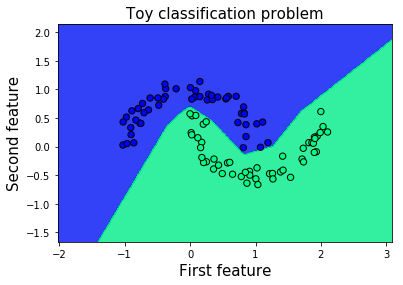

In [52]:
# Create a mesh to plot in
x_min, x_max = X[:, 0].numpy().min() - 1, X[:, 0].numpy().max() + 1
y_min, y_max = X[:, 1].numpy().min() - 1, X[:, 1].numpy().max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01),
                     np.arange(y_min, y_max, 0.01))

# Predict target for each sample xx, yy
Z = np.argmax(model.predict(tf.constant(np.c_[xx.ravel(), yy.ravel()])).numpy(), axis=1)

# Put the result into a color plot
Z = Z.reshape(xx.shape)
fig = plt.figure()
plt.contourf(xx, yy, Z, cmap=plt.cm.winter, alpha=0.8)

# Plot our training points
plt.scatter(X[:, 0].numpy(), X[:, 1].numpy(), c=y, s=40, cmap=plt.cm.winter, edgecolors='k')
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.xlabel('First feature', fontsize=15)
plt.ylabel('Second feature', fontsize=15)
plt.title('Toy classification problem', fontsize=15)
plt.show()